In [118]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser
import math
from datetime import date
from datetime import datetime, timedelta
from vega_datasets import data
import altair as alt
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
import seaborn as sns
import re

In [119]:
today = date.today()
print(today)

2020-08-28


In [120]:
# source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
ecdc = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", encoding = "utf-8")
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,28/08/2020,28,8,2020,3,0,Afghanistan,AF,AFG,38041757.0,Asia,1.853227
1,27/08/2020,27,8,2020,55,4,Afghanistan,AF,AFG,38041757.0,Asia,2.053007
2,26/08/2020,26,8,2020,1,0,Afghanistan,AF,AFG,38041757.0,Asia,2.108210
3,25/08/2020,25,8,2020,71,10,Afghanistan,AF,AFG,38041757.0,Asia,2.670749
4,24/08/2020,24,8,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,2.484112


In [121]:
#excluding NANs
countries_list = ecdc[ecdc['countryterritoryCode'].notnull()]['countryterritoryCode'].unique()

In [122]:
len(countries_list)

209

In [123]:
ecdc[ecdc['countryterritoryCode']=='DEU'].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
13888,28/08/2020,28,8,2020,1571,3,Germany,DE,DEU,83019213.0,Europe,20.875891
13889,27/08/2020,27,8,2020,1507,5,Germany,DE,DEU,83019213.0,Europe,20.732550
13890,26/08/2020,26,8,2020,1576,3,Germany,DE,DEU,83019213.0,Europe,20.749414
13891,25/08/2020,25,8,2020,1278,5,Germany,DE,DEU,83019213.0,Europe,20.274825
13892,24/08/2020,24,8,2020,711,3,Germany,DE,DEU,83019213.0,Europe,20.035121


# configure date to be datetime

In [124]:
ecdc['parsed_date'] = [re.sub(r'(\d\d)\/(\d\d)\/(\d\d\d\d)','\g<3>-\g<2>-\g<1>', date) for date in ecdc['dateRep']]
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,parsed_date
0,28/08/2020,28,8,2020,3,0,Afghanistan,AF,AFG,38041757.0,Asia,1.853227,2020-08-28
1,27/08/2020,27,8,2020,55,4,Afghanistan,AF,AFG,38041757.0,Asia,2.053007,2020-08-27
2,26/08/2020,26,8,2020,1,0,Afghanistan,AF,AFG,38041757.0,Asia,2.108210,2020-08-26
3,25/08/2020,25,8,2020,71,10,Afghanistan,AF,AFG,38041757.0,Asia,2.670749,2020-08-25
4,24/08/2020,24,8,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,2.484112,2020-08-24


In [125]:
ecdc['parsed_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in ecdc['parsed_date']]

In [126]:
# check whether latest date is today
ecdc['parsed_date'][0] == datetime.strptime(str(today),'%Y-%m-%d')

True

# Classify countries

In [127]:
moredouble = '01_moredouble'
more = '02_more'
samesame ='03_samesame'
less = '04_less'
lesshalf = '05_lesshalf'
zerozero ='06_zerozero'

In [128]:
list_country_dicts = []


for country in countries_list:
    country_dict = {}
    #filter dataframe for one specific country at a time
    filtered_aggregates = ecdc[ecdc['countryterritoryCode']==country]
    country_dict['country_ISO'] = country
    #filter country-specific-dataframe to only contain the last seven days ("this week")
    fourteen_days_ago = today-timedelta(14)
    country_dict['today'] = today
    country_dict['14_days_ago'] = fourteen_days_ago
    filtered_aggregates_this_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=today) & (filtered_aggregates['parsed_date']>fourteen_days_ago)]
    cases_this_two_weeks = filtered_aggregates_this_week['cases'].sum()
    country_dict['cases_this_two_weeks']= cases_this_two_weeks
    #filter country-specific-dataframe to only contain the previous seven days ("last week")    
    twentyeight_days_ago = today-timedelta(28)
    country_dict['28_days_ago'] = twentyeight_days_ago
    filtered_aggregates_last_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=fourteen_days_ago) &(filtered_aggregates['parsed_date']>twentyeight_days_ago)]
    cases_previous_two_weeks = filtered_aggregates_last_week['cases'].sum()
    country_dict['cases_previous_two_week']= cases_previous_two_weeks
    threshold_samesame = cases_previous_two_weeks * 0.02
    # classify country -- verbal description: see README.md
    if (cases_previous_two_weeks>0)&(cases_this_two_weeks > (cases_previous_two_weeks * 2)):
        country_dict['trend_class'] = moredouble
    elif (cases_previous_two_weeks >0) & (cases_this_two_weeks >= (cases_previous_two_weeks+threshold_samesame)):
        country_dict['trend_class'] = more
    elif (cases_previous_two_weeks == 0)& (cases_this_two_weeks !=0):
        country_dict['trend_class'] = more
    elif (cases_previous_two_weeks==0)&(cases_this_two_weeks==0):
        country_dict['trend_class'] = zerozero
    elif (cases_previous_two_weeks >0) & (cases_this_two_weeks == cases_previous_two_weeks):
        country_dict['trend_class'] = samesame
    elif (cases_this_two_weeks == 0)&(cases_previous_two_weeks != 0):
        country_dict['trend_class'] = less
    elif (cases_previous_two_weeks >0) &((cases_previous_two_weeks + threshold_samesame) > cases_this_two_weeks > (cases_previous_two_weeks - threshold_samesame)):
        country_dict['trend_class'] = samesame
    elif cases_this_two_weeks < cases_previous_two_weeks/2:
        country_dict['trend_class'] = lesshalf
    elif cases_this_two_weeks <= (cases_previous_two_weeks-threshold_samesame):
        country_dict['trend_class'] = less
    else:
        country_dict['trend_class'] = 'youMISSEDsth'
    # add it all to the list of country dicts
    list_country_dicts.append(country_dict)

/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  del sys.path[0]
/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


In [129]:
two_week_trend = pd.DataFrame(list_country_dicts)
two_week_trend.head()

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less


In [130]:
two_week_trend['trend_class'].value_counts()

04_less          73
02_more          70
01_moredouble    29
05_lesshalf      16
06_zerozero      11
03_samesame      10
Name: trend_class, dtype: int64

# Check for unclassified countries and other classes

In [131]:
len(two_week_trend[two_week_trend['trend_class']=='youMISSEDsth'])

0

In [132]:
two_week_trend[two_week_trend['trend_class']=='04_less']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less
6,2020-08-14,2020-07-31,2,1,ATG,2020-08-28,04_less
8,2020-08-14,2020-07-31,2473,2247,ARM,2020-08-28,04_less
12,2020-08-14,2020-07-31,2355,1929,AZE,2020-08-28,04_less
16,2020-08-14,2020-07-31,34,21,BRB,2020-08-28,04_less
18,2020-08-14,2020-07-31,8347,5462,BEL,2020-08-28,04_less
20,2020-08-14,2020-07-31,231,144,BEN,2020-08-28,04_less
23,2020-08-14,2020-07-31,19837,18058,BOL,2020-08-28,04_less


In [133]:
two_week_trend[two_week_trend['trend_class']=='03_samesame']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
14,2020-08-14,2020-07-31,4971,5030,BHR,2020-08-28,03_samesame
25,2020-08-14,2020-07-31,3740,3736,BIH,2020-08-28,03_samesame
31,2020-08-14,2020-07-31,121,119,BFA,2020-08-28,03_samesame
42,2020-08-14,2020-07-31,147785,148217,COL,2020-08-28,03_samesame
81,2020-08-14,2020-07-31,11458,11572,GTM,2020-08-28,03_samesame
119,2020-08-14,2020-07-31,165,167,MYS,2020-08-28,03_samesame
123,2020-08-14,2020-07-31,352,355,MRT,2020-08-28,03_samesame
152,2020-08-14,2020-07-31,58152,58055,PHL,2020-08-28,03_samesame
164,2020-08-14,2020-07-31,12,12,STP,2020-08-28,03_samesame
203,2020-08-14,2020-07-31,12510,12529,VEN,2020-08-28,03_samesame


In [134]:
two_week_trend[two_week_trend['trend_class']=='02_more'].head(30)

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more
7,2020-08-14,2020-07-31,89578,101614,ARG,2020-08-28,02_more
9,2020-08-14,2020-07-31,774,954,ABW,2020-08-28,02_more
13,2020-08-14,2020-07-31,581,834,BHS,2020-08-28,02_more
15,2020-08-14,2020-07-31,34226,35468,BGD,2020-08-28,02_more
17,2020-08-14,2020-07-31,1538,1962,BLR,2020-08-28,02_more
19,2020-08-14,2020-07-31,308,462,BLZ,2020-08-28,02_more
22,2020-08-14,2020-07-31,30,53,BTN,2020-08-28,02_more
26,2020-08-14,2020-07-31,410,419,BWA,2020-08-28,02_more


In [135]:
two_week_trend[two_week_trend['trend_class']=='01_moredouble'].head(30)

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
11,2020-08-14,2020-07-31,1721,3651,AUT,2020-08-28,01_moredouble
21,2020-08-14,2020-07-31,3,9,BMU,2020-08-28,01_moredouble
28,2020-08-14,2020-07-31,1,17,VGB,2020-08-28,01_moredouble
39,2020-08-14,2020-07-31,14,55,TCD,2020-08-28,01_moredouble
47,2020-08-14,2020-07-31,979,3142,HRV,2020-08-28,01_moredouble
49,2020-08-14,2020-07-31,3,21,CUW,2020-08-28,01_moredouble
61,2020-08-14,2020-07-31,6,32,ERI,2020-08-28,01_moredouble
64,2020-08-14,2020-07-31,9589,20203,ETH,2020-08-28,01_moredouble
69,2020-08-14,2020-07-31,22792,50333,FRA,2020-08-28,01_moredouble
70,2020-08-14,2020-07-31,88,203,PYF,2020-08-28,01_moredouble


# Count countries per category

In [136]:
current_status = two_week_trend['trend_class'].value_counts().rename_axis('trend_class').reset_index(name='number_of_countries')

In [137]:
current_status.sort_values(by='trend_class')

,trend_class,number_of_countries
2,01_moredouble,29
1,02_more,70
5,03_samesame,10
0,04_less,73
3,05_lesshalf,16
4,06_zerozero,11


In [138]:
current_status['number_of_countries'].sum()

209

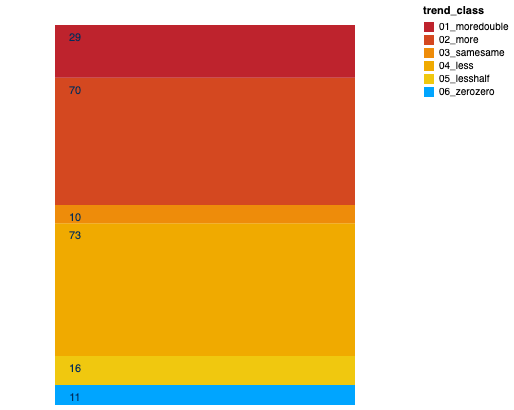

In [139]:
chart = alt.Chart(current_status).mark_bar(opacity=1,width=300).encode(
    y=alt.Y('sum(number_of_countries):Q', stack='zero', axis=None),
    color=alt.Color('trend_class:N',scale=alt.Scale(domain=[moredouble, more,samesame,less, lesshalf,zerozero],range=["#BE232D","#D44820","#EE8C0A","#F0AA00","#F0C80F","#00A5FF"]))
    #color=alt.Color('trend_class:N',scale=alt.Scale(domain=['01_moredouble', '02_more','03_samesame','04_less', '05_lesshalf','06_zerozero'],range=["#BE232D","#EE8C0A","#F0C80F","#00A5FF","#002D5A","#96BE00"]))
).properties(
    width=400, 
    height=400
)

numbers_labels = alt.Chart(current_status).mark_text(dx=-130, dy=13, color='#002D5A').encode(
    y=alt.Y('sum(number_of_countries):Q', stack = 'zero', axis = None),
    detail='trend_class:N',
    text=alt.Text('sum(number_of_countries):Q', format='.0f'),
)

labeled_chart = chart + numbers_labels
labeled_chart.configure_view(
   strokeOpacity=0
)


# List countries in each class

In [140]:
trend_classes = ['01_moredouble', '02_more', '03_samesame', '04_less', '05_lesshalf', '06_zerozero']

In [141]:
two_week_trend.head()

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less


In [142]:
regions = pd.read_csv('data/country-and-continent-codes-list.csv', delimiter = ";")
regions.columns =(['continent', 'region', 'subregion', 'country', 'numeric_ISO','country_ISO', 'ISO-alpha2 code', 'Other groupings'])
regions.head()

,continent,region,subregion,country,numeric_ISO,country_ISO,ISO-alpha2 code,Other groupings
0,Asia,Southern Asia,Southern Asia,Afghanistan,4.0,AFG,AF,LDC LLDC
1,Europe,Southern Europe,Southern Europe,Albania,8.0,ALB,AL,NaN
2,Americas,Northern America,Northern America,Antarctica,10.0,ATA,AQ,NaN
3,Africa,Northern Africa,Northern Africa,Algeria,12.0,DZA,DZ,NaN
4,Oceania,Polynesia,Polynesia,American Samoa,16.0,ASM,AS,SIDS


In [143]:
two_week_trend = two_week_trend.merge(regions[['country_ISO','numeric_ISO', 'continent', 'country']], left_on='country_ISO', right_on='country_ISO')
two_week_trend.head()

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less,4.0,Asia,Afghanistan
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more,8.0,Europe,Albania
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less,12.0,Africa,Algeria
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more,20.0,Europe,Andorra
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less,24.0,Africa,Angola


# Inspect single countries

In [144]:
two_week_trend[two_week_trend['country_ISO'] == 'GBR']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
196,2020-08-14,2020-07-31,12626,15441,GBR,2020-08-28,02_more,826.0,Europe,United Kingdom of Great Britain and Northern I...


# Add DW Languages for adaptation

In [145]:
# read in translation document
# url='https://deutschewelle-my.sharepoint.com/:x:/g/personal/gianna_gruen_dw_com/EWTbLap97ZNGvkCqkmU4dpUBBScuBFQ6kic-1qdTVsoWiQ?e=EtFHfg'
dw_languages = pd.read_excel('data/CountryCodes_Names_DW_Languages.xlsx')
dw_languages.head()

,country_ISO,english ISO name,DW_English,Hindi,Pashto,Dari
0,AFG,Afghanistan,Afghanistan,अफगानिस्तान,افغانستان,افغانستان
1,ALB,Albania,Albania,अल्बानिया,البانيا,البانيا
2,DZA,Algeria,Algeria,अल्जीरिया,الجزاير,الجزاير
3,AND,Andorra,Andorra,अंडोरा,اندورا,اندورا
4,AGO,Angola,Angola,अंगोला,انگولا,انگولا


In [146]:
dw_languages.columns

Index(['country_ISO', 'english ISO name', 'DW_English', 'Hindi', 'Pashto',
       'Dari'],
      dtype='object')

In [147]:
# merge two_week_trend with translation on ISO code
two_week_trend_with_languages = two_week_trend.merge(dw_languages, left_on='country_ISO', right_on='country_ISO')
two_week_trend_with_languages.head()

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country,english ISO name,DW_English,Hindi,Pashto,Dari
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less,4.0,Asia,Afghanistan,Afghanistan,Afghanistan,अफगानिस्तान,افغانستان,افغانستان
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more,8.0,Europe,Albania,Albania,Albania,अल्बानिया,البانيا,البانيا
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less,12.0,Africa,Algeria,Algeria,Algeria,अल्जीरिया,الجزاير,الجزاير
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more,20.0,Europe,Andorra,Andorra,Andorra,अंडोरा,اندورا,اندورا
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less,24.0,Africa,Angola,Angola,Angola,अंगोला,انگولا,انگولا


In [148]:
# read in full text length of trend classes in different languages
trend_classes = pd.read_excel('data/trend_classes.xlsx')
trend_classes.head()

,trend_class,DW_English,Hindi,Indonesian,Pashto,Dari
0,01_moredouble,More than twice as many new cases this week as...,इस हफ्ते पिछले हफ्ते से दोगुने से ज्यादा नए मा...,Kasus baru pekan ini lebih dua kali lipat diba...,د تیرې اوونۍ په پرتله یې دوه برابره ډیرې نوې پ...,دو برابر واقعات جدید در مقایسه با هفته قبل
1,02_more,More new cases this week than last week:,इस हफ्ते पिछले हफ्ते से ज्यादा नए मामले:,Kasus baru pekan ini lebih banyak dibanding pe...,د تیرې اوونۍ په پرتله یې ډیرې نوې پیښې لرلي دي,واقعات جدید بیشتر از هفته گذشته
2,03_samesame,About the same number of new cases in both wee...,इस हफ्ते भी पिछले हफ्ते जितने नए मामले (कोई बद...,Jumlah kasus sama dalam dua pekan (tidak ada p...,په دواړو اوونیو کې یې څه نا څه په عین اندازه ن...,تقریباً با عین واقعات جدید در هر دو هفتهتقریبا...
3,04_less,Fewer new cases this week than last week:,पिछले हफ्ते के मुकाबले कम नए मामले:,Lebih sedikit kasus dibanding pekan lalu,د تیرې اوونۍ په پرتله یې لږ نوې پیښې لرلي دي,موارد جدید کمتر در مقایسه با هفته های گذشته
4,05_lesshalf,Less than half as many new cases as last week:,पिछले हफ्ते के मुकाबले आधे के कम नए मामले:,Kurang dari separuh kasus dibanding pekan lalu,د تیرې اوونۍ په پرتله یې تر نیمایي کمې نوې پیښ...,شمار واقعات جدید، به اندازه کمتر از نیم واقعات...


In [149]:
#continent_list = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

In [150]:
continents = pd.read_excel('data/Continent_Names_Languages.xlsx')
continents

,continent,DW_English,Hindi,Indonesian,Pashto,Dari
0,Asia,Asia,एशिया,Asia,اسیا,آسیا
1,Africa,Africa,अफ्रीका,Afrika,افریقا,افریقا
2,Americas,Americas,अमेरिका,Amerika,امریکا,امریکا
3,Europe,Europe,यूरोप,Eropa,اروپا,اروپا
4,Oceania,Oceania,ओसिएनिया,Oceania,اقیانوسیه,اقیانوسیه


In [151]:
def countries_list_adapted(language):
    #create a text file for each language to paste the print outputs to
    filename = 'data-export/ClassifiedCountries/ClassifiedCountries-'+str(today)+'-'+language+'.txt'
    f = open(filename, "w")
    #loop through each trend class and create a specific df for this class
    for trend_class in trend_classes['trend_class']:
        trend_class_df = two_week_trend_with_languages[two_week_trend_with_languages['trend_class'] == trend_class]
        
        # find the class' index to replace the variable name with full length text
        index_formatted=trend_classes[trend_classes['trend_class']==trend_class].index
        index_number = index_formatted[0]
        print('   ', file=f)
        print(trend_classes[trend_classes['trend_class']==trend_class][language][index_number], file=f)
        
        #loop through all countries in this class and add them to the list
        for continent in continents['continent']:#
            continent_trend_class = trend_class_df[trend_class_df['continent']==continent]
            index_formatted_c=continents[continents['continent']==continent].index #
            index_number_c = index_formatted_c[0] #
            print('   ', file=f) #
            print(continents[continents['continent']==continent][language][index_number_c]+':', file=f) #
            for country in continent_trend_class[language]:
                print(country+', ', file=f)
    f.close() #save unformatted list to text file
    
    # clean printout statements with regular expressions
    f = open(filename, "r") # open unformatted list for formatting
    original = f.read()
    cleaned = re.sub(r", \n", ", ", original) # get rid of linebreaks between country names
    cleaned = re.sub(r",    (\n\w*\:)","\g<1>",cleaned) # delete the comma and blanks behind the last country in continents, except for last country in each category
    cleaned = re.sub(r"(:)\n(\w)","\g<1> \g<2>", cleaned) # get rid of linebreaks between continent names and countries
    cleaned = re.sub(r",    \n", "\n\n",cleaned) # add additional line between classes, delete last categoy's country's comma
    print(cleaned)

In [152]:
countries_list_adapted('DW_English')

   
More than twice as many new cases this week as last week:
   
Asia: Jordan, Lebanon, Myanmar, South Korea
Africa: Chad, Eritrea, Ethiopia, Namibia, Rwanda, Somalia, Tunisia, Uganda
Americas: Bermuda, British Virgin Islands, Curacao, Guyana, Jamaica, Paraguay, Trinidad and Tobago
Europe: Austria, Croatia, France, Gibraltar, Italy, Liechtenstein, Slovenia
Oceania: French Polynesia, Guam, New Zealand

More new cases this week than last week:
   
Asia: Bangladesh, Bhutan, Brunei Darussalam, Georgia, India, Indonesia, Iraq, Israel, Kuwait, Lao People's Democratic Republic, Maldives, Nepal, Palestinian territories, Sri Lanka, Syria, Timor Leste, Turkey, United Arab Emirates
Africa: Botswana, Gambia, Guinea, Lesotho, Libya, Mali, Mauritius, Morocco, Mozambique, Sudan, Togo
Americas: Argentina, Aruba, Bahamas, Belize, Canada, Cayman Islands, Costa Rica, Cuba, Dominica, Honduras, Peru, Saint Lucia, Sint Maarten (Dutch part), Turks and Caicos islands, US Virgin Islands
Europe: Albania, Andor

In [153]:
two_week_trend[two_week_trend['country_ISO']=='DEU']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
74,2020-08-14,2020-07-31,13478,17331,DEU,2020-08-28,02_more,276.0,Europe,Germany


# Make maps of regions

In [157]:
two_week_trend.head()

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
0,2020-08-14,2020-07-31,882,705,AFG,2020-08-28,04_less,4.0,Asia,Afghanistan
1,2020-08-14,2020-07-31,1774,2112,ALB,2020-08-28,02_more,8.0,Europe,Albania
2,2020-08-14,2020-07-31,7356,5829,DZA,2020-08-28,04_less,12.0,Africa,Algeria
3,2020-08-14,2020-07-31,59,117,AND,2020-08-28,02_more,20.0,Europe,Andorra
4,2020-08-14,2020-07-31,684,653,AGO,2020-08-28,04_less,24.0,Africa,Angola


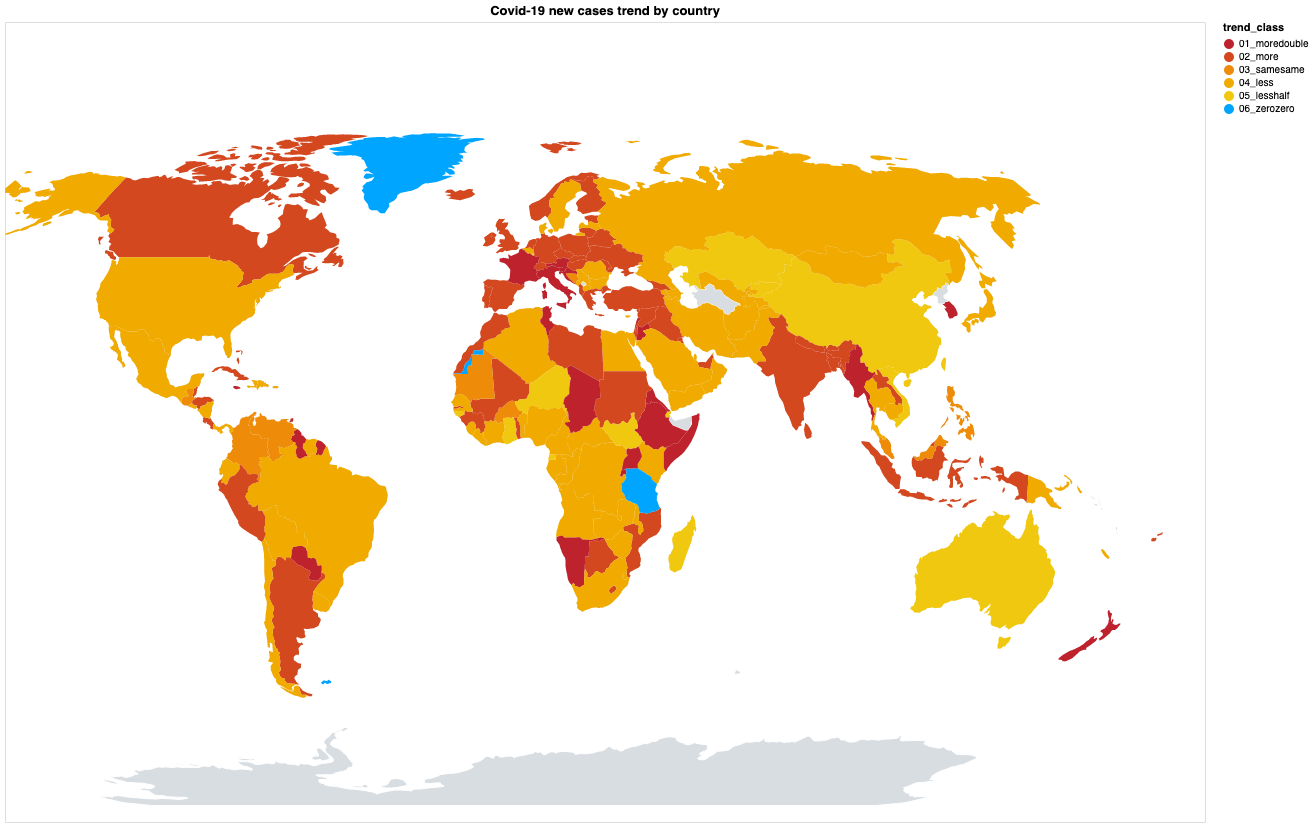

In [158]:
countries = alt.topo_feature(data.world_110m.url, "countries")

projection_type="naturalEarth1"
scale_value=240
center_values=[25,10]

base = alt.Chart(countries).mark_geoshape(
    fill='#D8DDE2',
    stroke='white'
).properties(
    width=1200,
    height=800,
).project(
    type=projection_type,
    center=center_values,
    scale=scale_value
)

variable_list = ['01_moredouble', '02_more', '03_samesame', '04_less', '05_lesshalf', '06_zerozero']
visualized_parameter = 'trend_class'
tooltip=visualized_parameter+':N'

chart = alt.Chart(countries).mark_geoshape().encode(
    alt.Color(visualized_parameter, type ='ordinal', scale=alt.Scale(domain=variable_list,range=["#BE232D","#D44820","#EE8C0A","#F0AA00","#F0C80F","#00A5FF"])),
    tooltip=["country:N", tooltip]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(two_week_trend,'numeric_ISO',['country', visualized_parameter])
).project(
    type=projection_type,
    center=center_values,
    scale=scale_value
).properties(
    width=1200,
    height=800,
    title='Covid-19 new cases trend by country'
)

base + chart

countries not colored
* United Arab Emirates  ARE 784 in dataset, with data
* Kosovo                XKX nan is in dataset, with data

* Turkmenistan          TKM 795 not in dataset
* North Korea           PRK 408 not in dataset

In [159]:
two_week_trend[two_week_trend['country_ISO']=='XKX']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
105,2020-08-14,2020-07-31,2691,1888,XKX,2020-08-28,04_less,NaN,Europe,Kosovo


In [160]:
two_week_trend[two_week_trend['country_ISO']=='ARE']

,14_days_ago,28_days_ago,cases_previous_two_week,cases_this_two_weeks,country_ISO,today,trend_class,numeric_ISO,continent,country
195,2020-08-14,2020-07-31,2983,5022,ARE,2020-08-28,02_more,784.0,Asia,United Arab Emirates


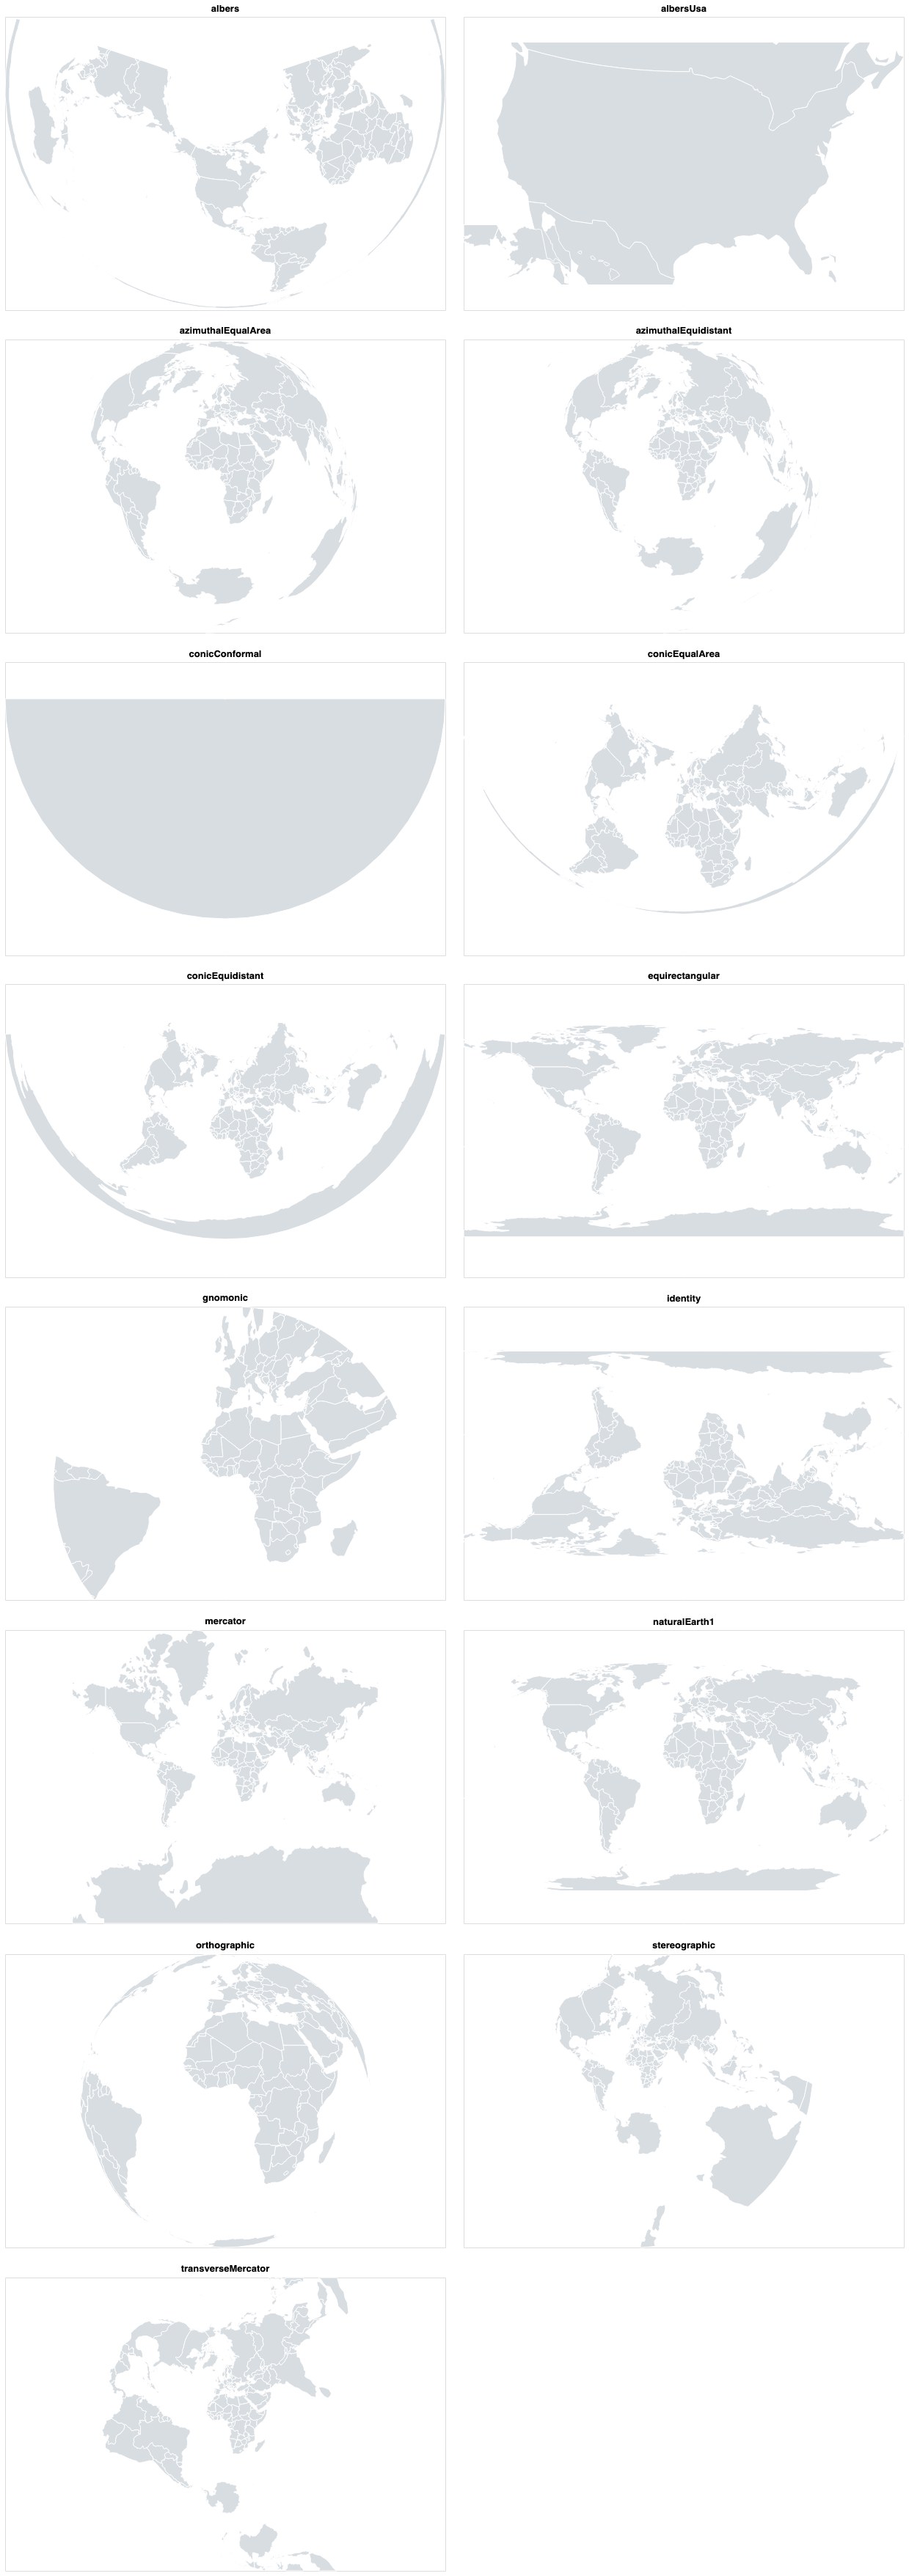

In [161]:
countries = alt.topo_feature(data.world_110m.url, "countries")

projection_type="naturalEarth1"

base = alt.Chart(countries).mark_geoshape(
    fill='#D8DDE2',
    stroke='white'
).properties(
    width=600,
    height=400,
)
projections = ['albers', 'albersUsa', 'azimuthalEqualArea', 'azimuthalEquidistant', 'conicConformal', 'conicEqualArea', 'conicEquidistant', 'equirectangular', 'gnomonic', 'identity', 'mercator', 'naturalEarth1', 'orthographic', 'stereographic', 'transverseMercator']
charts = [base.project(proj).properties(title=proj)
          for proj in projections]

alt.concat(*charts, columns=2)